# MLPModel模型

In [1]:
import numpy as np
from mlp_retrosyn.mlp_policies import load_parallel_model , preprocess
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import torch
import torch.nn.functional as F
import os

In [2]:
def preprocess(X,fp_dim):   #计算分子指纹,只能计算smiles，反应规则smarts不行
    mol = Chem.MolFromSmiles(X)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=int(fp_dim),useChirality=True)
    onbits = list(fp.GetOnBits())
    arr = np.zeros(fp.GetNumBits())
    arr[onbits] = 1
    # arr = (arr - arr.mean())/(arr.std() + 0.000001)
    # arr = arr / fp_dim
    # X = fps_to_arr(X)
    return arr

In [3]:
fp_dim=2048
#x='OCC(=O)OCCCO'
#x='O=C1C2([H])C=C(CO)[C@@H](O)[C@]3(O)[C@@H](O)C(C)=C[C@@]31[C@H](C)C[C@]4([H])[C@@]2([H])C4(C)C'   #复杂的天然产物
#x='C/C1=C/CC[C@H](C)C(O[C@H]1CC2=C(C)COC2=O)=O' #中等难度
#x='O=C1C=CC2=C(CC[C@H](CC)[C@@H]2O)O1'           #简单难度
x='[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[n:15]1[c:14]2[cH:13][cH:12][c:11]([C:9]([CH3:8])=[O:10])[cH:19][c:18]2[cH:17][cH:16]1'
arr = preprocess(x, fp_dim)    #计算分子指纹
print(arr,'\n',arr.shape)
arr = np.reshape(arr,[-1, arr.shape[0]])    #arr.shape[0]=2048
print(arr,'\n',arr.shape)
arr = torch.tensor(arr, dtype=torch.float32)
print(arr,'\n',arr.shape)


[0. 0. 0. ... 0. 0. 0.] 
 (2048,)
[[0. 0. 0. ... 0. 0. 0.]] 
 (1, 2048)
tensor([[0., 0., 0.,  ..., 0., 0., 0.]]) 
 torch.Size([1, 2048])


In [4]:
#dirpath = os.path.dirname(os.path.abspath(__file__))        #定位到当前目录下,不可以直接在命令行运行该文件， 否则会报错 “NameError: name '__file__' is not defined”
dirpath = '/home/Flow/Learning/CASI/retro_star/retro_star'
state_path=dirpath+'/one_step_model/saved_rollout_state_1_2048.ckpt'
template_path=dirpath+'/one_step_model/template_rules_1.dat'
net, idx2rules = load_parallel_model(state_path,template_path, fp_dim)

template rules: 381302it [00:00, 1907248.47it/s]


In [5]:
net.eval()
preds = net(arr)               #通过神经网络的预测
print(preds)
print(preds.shape)
preds = F.softmax(preds,dim=1)      #按行进行softmax函数
print(preds)
print(preds.shape)
print(sum(preds[0]))

tensor([[ 1.6429,  2.0104,  4.4761,  ..., -6.3988, -6.0725, -6.0204]],
       grad_fn=<AddmmBackward0>)
torch.Size([1, 381302])
tensor([[5.4017e-09, 7.8008e-09, 9.1836e-08,  ..., 1.7381e-12, 2.4087e-12,
         2.5375e-12]], grad_fn=<SoftmaxBackward0>)
torch.Size([1, 381302])
tensor(0.9999, grad_fn=<AddBackward0>)


In [6]:
probs, idx = torch.topk(preds,k=10)   #preds中前k=10大的预测
print(probs,'\n',idx)
print(sum(probs[0]))

tensor([[9.9309e-01, 1.1610e-03, 8.7165e-04, 7.3233e-04, 6.6345e-04, 4.9619e-04,
         4.3581e-04, 3.3747e-04, 1.9059e-04, 1.8568e-04]],
       grad_fn=<TopkBackward0>) 
 tensor([[ 39176, 102524,   1353,  79148, 132444,   6903,  79830,   1360, 106913,
         153577]])
tensor(0.9982, grad_fn=<AddBackward0>)


In [7]:
rule_k = [idx2rules[id] for id in idx[0].numpy().tolist()] #预测出的前k个最有可能反应的规则
print(len(rule_k))
n=1
for i in rule_k:
    print('第',n,'条规则:',i)
    n=n+1

10
第 1 条规则: ([C;D1;H3:1]-[C:2](-[C;D1;H3:3])(-[C;D1;H3:4])-[#8:5]-[C;H0;D3;+0:6](=[O;D1;H0:7])-[n;H0;D3;+0:9](:[c:8]):[c:10])>>[C;D1;H3:1]-[C:2](-[C;D1;H3:3])(-[C;D1;H3:4])-[#8:5]-[C;H0;D3;+0:6](=[O;D1;H0:7])-O-[C;H0;D3;+0:6](=[O;D1;H0:7])-[#8:5]-[C:2](-[C;D1;H3:1])(-[C;D1;H3:3])-[C;D1;H3:4].[c:8]:[nH;D2;+0:9]:[c:10]
第 2 条规则: ([CH3;D1;+0:1]-[C;H0;D3;+0:2](=[O;D1;H0:3])-[c:4])>>Br-[Mg]-[CH3;D1;+0:1].C-O-N(-C)-[C;H0;D3;+0:2](=[O;D1;H0:3])-[c:4]
第 3 条规则: ([C;D1;H3:1]-[C;H0;D3;+0:2](=[O;H0;D1;+0:3])-[c:4])>>[C;D1;H3:1]-[CH;D3;+0:2](-[OH;D1;+0:3])-[c:4]
第 4 条规则: ([C;D1;H3:6]-[C;H0;D3;+0:5](=[O;H0;D1;+0:4])-[c;H0;D3;+0:1](:[c:2]):[c:3])>>Br-[c;H0;D3;+0:1](:[c:2]):[c:3].C-C-C-C-[Sn](-C-C-C-C)(-C-C-C-C)-C(=C)-[O;H0;D2;+0:4]-[CH2;D2;+0:5]-[C;D1;H3:6]
第 5 条规则: ([C;D1;H3:5]-[C:4](-[C;D1;H3:6])(-[C;D1;H3:7])-[#8:3]-[C;H0;D3;+0:2](=[O;H0;D1;+0:1])-[n;H0;D3;+0:9](:[c:8]):[c:10])>>C-C(-C)(-C)-O-C(=O)-[O;H0;D2;+0:1]-[C;H0;D3;+0:2](=O)-[#8:3]-[C:4](-[C;D1;H3:5])(-[C;D1;H3:6])-[C;D1;H3:7].[c:8]:[nH;D2;+

In [8]:
from rdchiral.main import rdchiralRunText, rdchiralRun
reactants = []
scores = []
templates = []
for i , rule in enumerate(rule_k):
    out1 = []
    try:
        out1 = rdchiralRunText(rule, x) #返回根据规则最有可能分解成的分子结果
        print('第',i+1,'条规则:\n',rule)
        print('第',i+1,'条规则下可能生成的结果：\n',out1,'\n')
        # out1 = rdchiralRunText(rule, Chem.MolToSmiles(Chem.MolFromSmarts(x)))
        if len(out1) == 0: continue     #没有结果，则跳出本次循环
        # if len(out1) > 1: print("more than two reactants."),print(out1)
        out1 = sorted(out1)
        for reactant in out1:
            reactants.append(reactant)
            scores.append(probs[0][i].item()/len(out1))
            templates.append(rule)
    # out1 = rdchiralRunText(x, rule)
    except ValueError:
        pass
print(reactants)
print(scores)
print(templates)

第 1 条规则:
 ([C;D1;H3:1]-[C:2](-[C;D1;H3:3])(-[C;D1;H3:4])-[#8:5]-[C;H0;D3;+0:6](=[O;D1;H0:7])-[n;H0;D3;+0:9](:[c:8]):[c:10])>>[C;D1;H3:1]-[C:2](-[C;D1;H3:3])(-[C;D1;H3:4])-[#8:5]-[C;H0;D3;+0:6](=[O;D1;H0:7])-O-[C;H0;D3;+0:6](=[O;D1;H0:7])-[#8:5]-[C:2](-[C;D1;H3:1])(-[C;D1;H3:3])-[C;D1;H3:4].[c:8]:[nH;D2;+0:9]:[c:10]
第 1 条规则下可能生成的结果：
 ['CC(=O)c1ccc2[nH]ccc2c1.CC(C)(C)OC(=O)OC(=O)OC(C)(C)C'] 

第 2 条规则:
 ([CH3;D1;+0:1]-[C;H0;D3;+0:2](=[O;D1;H0:3])-[c:4])>>Br-[Mg]-[CH3;D1;+0:1].C-O-N(-C)-[C;H0;D3;+0:2](=[O;D1;H0:3])-[c:4]
第 2 条规则下可能生成的结果：
 ['CON(C)C(=O)c1ccc2c(ccn2C(=O)OC(C)(C)C)c1.C[Mg]Br'] 

第 3 条规则:
 ([C;D1;H3:1]-[C;H0;D3;+0:2](=[O;H0;D1;+0:3])-[c:4])>>[C;D1;H3:1]-[CH;D3;+0:2](-[OH;D1;+0:3])-[c:4]
第 3 条规则下可能生成的结果：
 ['CC(O)c1ccc2c(ccn2C(=O)OC(C)(C)C)c1'] 

第 4 条规则:
 ([C;D1;H3:6]-[C;H0;D3;+0:5](=[O;H0;D1;+0:4])-[c;H0;D3;+0:1](:[c:2]):[c:3])>>Br-[c;H0;D3;+0:1](:[c:2]):[c:3].C-C-C-C-[Sn](-C-C-C-C)(-C-C-C-C)-C(=C)-[O;H0;D2;+0:4]-[CH2;D2;+0:5]-[C;D1;H3:6]
第 4 条规则下可能生成的结果：
 ['C=C(OCC)[Sn](CCCC)

In [9]:
result=[]
result.append(x)
result.append(reactants[2])
result.append(reactants[3])
print(result)

['[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[n:15]1[c:14]2[cH:13][cH:12][c:11]([C:9]([CH3:8])=[O:10])[cH:19][c:18]2[cH:17][cH:16]1', 'CC(O)c1ccc2c(ccn2C(=O)OC(C)(C)C)c1', 'C=C(OCC)[Sn](CCCC)(CCCC)CCCC.CC(C)(C)OC(=O)n1ccc2cc(Br)ccc21']


In [10]:
from collections import defaultdict, OrderedDict
reactants_d = defaultdict(list)     #构建一个默认value为list的字典
for r, s, t in zip(reactants, scores, templates):   #将结果打包成字典
    if '.' in r:
        str_list = sorted(r.strip().split('.'))
        reactants_d['.'.join(str_list)].append((s, t))
    else:
        reactants_d[r].append((s, t))
print(reactants_d)

defaultdict(<class 'list'>, {'CC(=O)c1ccc2[nH]ccc2c1.CC(C)(C)OC(=O)OC(=O)OC(C)(C)C': [(0.9930921792984009, '([C;D1;H3:1]-[C:2](-[C;D1;H3:3])(-[C;D1;H3:4])-[#8:5]-[C;H0;D3;+0:6](=[O;D1;H0:7])-[n;H0;D3;+0:9](:[c:8]):[c:10])>>[C;D1;H3:1]-[C:2](-[C;D1;H3:3])(-[C;D1;H3:4])-[#8:5]-[C;H0;D3;+0:6](=[O;D1;H0:7])-O-[C;H0;D3;+0:6](=[O;D1;H0:7])-[#8:5]-[C:2](-[C;D1;H3:1])(-[C;D1;H3:3])-[C;D1;H3:4].[c:8]:[nH;D2;+0:9]:[c:10]'), (0.0006634477758780122, '([C;D1;H3:5]-[C:4](-[C;D1;H3:6])(-[C;D1;H3:7])-[#8:3]-[C;H0;D3;+0:2](=[O;H0;D1;+0:1])-[n;H0;D3;+0:9](:[c:8]):[c:10])>>C-C(-C)(-C)-O-C(=O)-[O;H0;D2;+0:1]-[C;H0;D3;+0:2](=O)-[#8:3]-[C:4](-[C;D1;H3:5])(-[C;D1;H3:6])-[C;D1;H3:7].[c:8]:[nH;D2;+0:9]:[c:10]')], 'CON(C)C(=O)c1ccc2c(ccn2C(=O)OC(C)(C)C)c1.C[Mg]Br': [(0.0011609819484874606, '([CH3;D1;+0:1]-[C;H0;D3;+0:2](=[O;D1;H0:3])-[c:4])>>Br-[Mg]-[CH3;D1;+0:1].C-O-N(-C)-[C;H0;D3;+0:2](=[O;D1;H0:3])-[c:4]')], 'CC(O)c1ccc2c(ccn2C(=O)OC(C)(C)C)c1': [(0.0008716508164070547, '([C;D1;H3:1]-[C;H0;D3;+0:2](=[O;H0;D1

In [11]:
def merge(reactant_d):
    ret = []
    for reactant, l in reactant_d.items():
        ss, ts = zip(*l)
        ret.append((reactant, sum(ss), list(ts)[0]))
    reactants, scores, templates = zip(*sorted(ret,key=lambda item : item[1], reverse=True))
    return list(reactants), list(scores), list(templates)

reactants, scores, templates = merge(reactants_d)
total = sum(scores)
scores = [s / total for s in scores]    #scores的归一化
print(reactants)
print(scores)
print(templates)


['CC(=O)c1ccc2[nH]ccc2c1.CC(C)(C)OC(=O)OC(=O)OC(C)(C)C', 'CON(C)C(=O)c1ccc2c(ccn2C(=O)OC(C)(C)C)c1.C[Mg]Br', 'CC(O)c1ccc2c(ccn2C(=O)OC(C)(C)C)c1', 'C=C(OCC)[Sn](CCCC)(CCCC)CCCC.CC(C)(C)OC(=O)n1ccc2cc(Br)ccc21', 'CC(C)(C)OC(=O)n1ccc2cc(C3(C)OCCO3)ccc21', 'CC(=O)c1ccc2[nH]ccc2c1.CC(C)(C)OC(=O)OC(C)(C)C', 'CC(=O)OC(C)=O.CC(C)(C)OC(=O)n1ccc2ccccc21', 'CC(C)(C)OC(=O)n1ccc2cc(Br)ccc21.CON(C)C(C)=O', 'CON(C)C(=O)c1ccc2c(ccn2C(=O)OC(C)(C)C)c1.C[Mg]Cl']
[0.995581184328034, 0.0011631147052334825, 0.0008732520636626986, 0.0007336756842084635, 0.0004971040056862067, 0.00043661416481227694, 0.00033809402668668866, 0.00019093952047074923, 0.00018602150120544005]
['([C;D1;H3:1]-[C:2](-[C;D1;H3:3])(-[C;D1;H3:4])-[#8:5]-[C;H0;D3;+0:6](=[O;D1;H0:7])-[n;H0;D3;+0:9](:[c:8]):[c:10])>>[C;D1;H3:1]-[C:2](-[C;D1;H3:3])(-[C;D1;H3:4])-[#8:5]-[C;H0;D3;+0:6](=[O;D1;H0:7])-O-[C;H0;D3;+0:6](=[O;D1;H0:7])-[#8:5]-[C:2](-[C;D1;H3:1])(-[C;D1;H3:3])-[C;D1;H3:4].[c:8]:[nH;D2;+0:9]:[c:10]', '([CH3;D1;+0:1]-[C;H0;D3;+0:2](=

In [12]:
result={'reactants':reactants,
        'scores' : scores,
        'template' : templates}
print(result.keys())

dict_keys(['reactants', 'scores', 'template'])


# Value网络测试

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import logging


class ValueMLP(nn.Module):
    def __init__(self, n_layers, fp_dim, latent_dim, dropout_rate, device):
        super(ValueMLP, self).__init__()
        self.n_layers = n_layers            #1     隐藏层数量，如果是2，就是两个128个神经元的隐藏层
        self.fp_dim = fp_dim                #2048
        self.latent_dim = latent_dim        #128
        self.dropout_rate = dropout_rate    #0.1
        self.device = device

        logging.info('Initializing value model: latent_dim=%d' % self.latent_dim)

        layers = []
        layers.append(nn.Linear(fp_dim, latent_dim))
        # layers.append(nn.BatchNorm1d(latent_dim,
        #                              track_running_stats=False))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(self.dropout_rate))
        for _ in range(self.n_layers - 1):
            layers.append(nn.Linear(latent_dim, latent_dim))
            # layers.append(nn.BatchNorm1d(latent_dim,
            #                              track_running_stats=False))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(self.dropout_rate))
        layers.append(nn.Linear(latent_dim, 1))

        self.layers = nn.Sequential(*layers)

    def forward(self, fps):
        x = fps
        x = self.layers(x)
        x = torch.log(1 + torch.exp(x))

        return x


In [15]:
gpu=-1
device = torch.device('cuda:%d' % gpu if gpu >= 0 else 'cpu')
model = ValueMLP(
                n_layers=1,
                fp_dim=fp_dim,
                latent_dim=128,
                dropout_rate=0.1,
                device=device
            ).to(device)
save_folder=dirpath+'/saved_models'
value_model='best_epoch_final_4.pt'
model_f = '%s/%s' % (save_folder, value_model)  #value_model：best_epoch_final_4.pt
model.load_state_dict(torch.load(model_f, map_location=device))
model.eval()
def smiles_to_fp(s, fp_dim=2048, pack=False):
    mol = Chem.MolFromSmiles(s)     #从smiles编码中获取结构信息
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=fp_dim)    #使用Morgan指纹来获取默认长度，并将其缩短为长度为2048的位数组时的长度
    onbits = list(fp.GetOnBits())
    arr = np.zeros(fp.GetNumBits(), dtype=np.bool)
    arr[onbits] = 1

    if pack:
        arr = np.packbits(arr)

    return arr
def value_fn(mol):
    fp = smiles_to_fp(mol, fp_dim=fp_dim).reshape(1, -1)
    fp = torch.FloatTensor(fp).to(device)
    v = model(fp).item()
    return v
#x='OCC(=O)OCCCO'
#x='[CH3:5][C:6]1[CH2:28][S:27][C@@H:9]2[C@H:10]([NH2:13])[C:11](=[O:12])[N:8]2[C:7]=1[C:29]([OH:31])=[O:30]'
x='O=C1C=CC2=C(CC[C@H](CC)[C@@H]2O)O1'
init_value = value_fn(x)
print(init_value)

0.8375192880630493


/home/Flow/.conda/envs/retro_star_env/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [16]:
import rdkit.Chem as Chem
from graphviz import Digraph
m1=Chem.MolFromSmiles('O=C1C=CC2=C(CC[C@H](CC)[C@@H]2O)O1')
m2=Chem.MolFromSmiles('OCC(=O)OCCCO')
img1=Chem.Draw.MolToImage(m1)
img2=Chem.Draw.MolToImage(m2)
G = Digraph('G')                #创建图G
G.attr('node', shape='box')     #节点node属性，方形
G.format = 'png'                #导出文件为png格式
#G.edge('O=C1C=CC2=C(CC[C@H](CC)[C@@H]2O)O1', 'OCC(=O)OCCCO', label='cost')
G.edge(img1,img2)
G.render()
G

SyntaxError: invalid syntax (_tools.py, line 23)

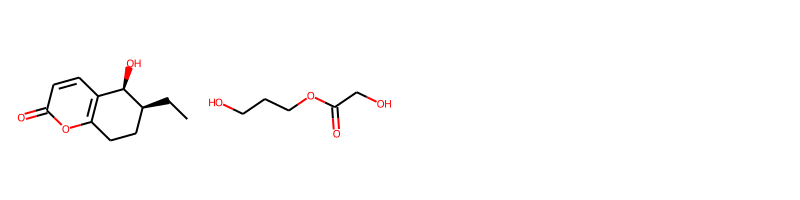

In [26]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
m1 = Chem.MolFromSmiles('O=C1C=CC2=C(CC[C@H](CC)[C@@H]2O)O1')
m2=Chem.MolFromSmiles('OCC(=O)OCCCO')
mols=[m1,m2]
Draw.MolsToGridImage(mols,molsPerRow=4,subImgSize=(200,200),legends=['' for x in mols])
img=Draw.MolsToGridImage(mols,subImgSize=(200,200),legends=['' for x in mols])
img.save('best_route.png')

In [ ]:
#一步反应，MLP找模板的算法是否靠谱
